This assignment is taken from Svetlana Lazebnik.

### Dawei Wang(dwang56)

### Common imports

In [2]:
%matplotlib inline
import os
import sys
import glob
import time
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from PIL import Image

### Provided functions
#### Image loading and saving

In [3]:
def LoadFaceImages(pathname, subject_name, num_images):
    """
    Load the set of face images.  
    The routine returns
        ambimage: image illuminated under the ambient lighting
        imarray: a 3-D array of images, h x w x Nimages
        lightdirs: Nimages x 3 array of light source directions
    """

    def load_image(fname):
        return np.asarray(Image.open(fname))

    def fname_to_ang(fname):
        yale_name = os.path.basename(fname)
        return int(yale_name[12:16]), int(yale_name[17:20])

    def sph2cart(az, el, r):
        rcos_theta = r * np.cos(el)
        x = rcos_theta * np.cos(az)
        y = rcos_theta * np.sin(az)
        z = r * np.sin(el)
        return x, y, z

    ambimage = load_image(
        os.path.join(pathname, subject_name + '_P00_Ambient.pgm'))
    im_list = glob.glob(os.path.join(pathname, subject_name + '_P00A*.pgm'))
    if num_images <= len(im_list):
        im_sub_list = np.random.choice(im_list, num_images, replace=False)
    else:
        print(
            'Total available images is less than specified.\nProceeding with %d images.\n'
            % len(im_list))
        im_sub_list = im_list
    im_sub_list.sort()
    imarray = np.stack([load_image(fname) for fname in im_sub_list], axis=-1)
    Ang = np.array([fname_to_ang(fname) for fname in im_sub_list])

    x, y, z = sph2cart(Ang[:, 0] / 180.0 * np.pi, Ang[:, 1] / 180.0 * np.pi, 1)
    lightdirs = np.stack([y, z, x], axis=-1)
    return ambimage, imarray, lightdirs

In [4]:
def save_outputs(subject_name, albedo_image, surface_normals):
    im = Image.fromarray((albedo_image*255).astype(np.uint8))
    im.save("%s_albedo.jpg" % subject_name)
    im = Image.fromarray((surface_normals[:,:,0]*128+128).astype(np.uint8))
    im.save("%s_normals_x.jpg" % subject_name)
    im = Image.fromarray((surface_normals[:,:,1]*128+128).astype(np.uint8))
    im.save("%s_normals_y.jpg" % subject_name)
    im = Image.fromarray((surface_normals[:,:,2]*128+128).astype(np.uint8))
    im.save("%s_normals_z.jpg" % subject_name)

#### Plot the albedo and the surface norms. 

In [5]:
def plot_albedo_and_surface_normals(albedo_image, surface_normals):
    """
    albedo_image: h x w matrix
    surface_normals: h x w x 3 matrix.
    """
    fig, axes = plt.subplots(1, 4, figsize=(10,2.5))
    ax = axes[0]
    ax.axis('off')
    ax.set_title('albedo')
    ax.imshow(albedo_image, cmap='gray')

    ax = axes[1]
    ax.axis('off')
    ax.set_title('X')
    im = ax.imshow(surface_normals[:,:,0], cmap='jet')
    ax = axes[2]
    ax.axis('off')
    ax.set_title('Y')
    im = ax.imshow(surface_normals[:,:,1], cmap='jet')
    ax = axes[3]
    ax.axis('off')
    ax.set_title('Z')
    im = ax.imshow(surface_normals[:,:,2], cmap='jet')

    fig.colorbar(im, ax=axes, fraction=0.02, aspect=15)

#### Plot the height map

In [6]:
def set_aspect_equal_3d(ax):
    """https://stackoverflow.com/questions/13685386"""
    """Fix equal aspect bug for 3D plots."""
    xlim = ax.get_xlim3d()
    ylim = ax.get_ylim3d()
    zlim = ax.get_zlim3d()
    from numpy import mean
    xmean = mean(xlim)
    ymean = mean(ylim)
    zmean = mean(zlim)
    plot_radius = max([
        abs(lim - mean_)
        for lims, mean_ in ((xlim, xmean), (ylim, ymean), (zlim, zmean))
        for lim in lims
    ])
    ax.set_xlim3d([xmean - plot_radius, xmean + plot_radius])
    ax.set_ylim3d([ymean - plot_radius, ymean + plot_radius])
    ax.set_zlim3d([zmean - plot_radius, zmean + plot_radius])

def display_3d(albedo_image, height_map, elev=20, azim=20):
    fig = plt.figure(figsize=(10, 10))
    ax = fig.gca(projection='3d')
    ax.view_init(elev, azim)
    X = np.arange(albedo_image.shape[0])
    Y = np.arange(albedo_image.shape[1])
    X, Y = np.meshgrid(Y, X)
    H = np.flipud(np.fliplr(height_map))
    A = np.flipud(np.fliplr(albedo_image))
    A = np.stack([A, A, A], axis=-1)
    ax.xaxis.set_ticks([])
    ax.xaxis.set_label_text('Z')
    ax.yaxis.set_ticks([])
    ax.yaxis.set_label_text('X')
    ax.zaxis.set_ticks([])
    ax.yaxis.set_label_text('Y')
    surf = ax.plot_surface(
        H, X, Y, cmap='gray', facecolors=A, linewidth=0, antialiased=False)
    set_aspect_equal_3d(ax)
    plt.savefig("3d "+str(elev)+" "+str(azim)+'.png')

---
### Your implementation

In [7]:
def preprocess(ambimage, imarray):
    """
    preprocess the data: 
        1. subtract ambient_image from each image in imarray.
        2. make sure no pixel is less than zero.
        3. rescale values in imarray to be between 0 and 1.
    Inputs:
        ambimage: h x w
        imarray: h x w x Nimages
    Outputs:
        processed_imarray: h x w x Nimages
    """

    processed_imarray = np.clip((imarray - np.expand_dims(ambimage, axis=2)) / 255, 0, 1)
    return processed_imarray

In [8]:
def photometric_stereo(imarray, light_dirs):
    """
    Inputs:
        imarray:  h x w x Nimages
        light_dirs: Nimages x 3
    Outputs:
        albedo_image: h x w
        surface_norms: h x w x 3
    """
    h, w, N = imarray.shape
    I = np.swapaxes(imarray.reshape((h * w, N)), 0, 1)
    G, residual = np.linalg.lstsq(light_dirs, I, rcond=None)[0:2]
    albedo_image = np.linalg.norm(G, axis=0)
    surface_normals = np.swapaxes(G / albedo_image, 0, 1)
    print("Mean residual of the least square: ", np.mean(residual))
    return albedo_image.reshape(h, w), surface_normals.reshape(h, w, 3)

In [9]:
def row_method(fx, fy):
    """
    First rows then columns.
    """
    surface = np.copy(fx)
    surface[:,0] += np.cumsum(fy[:,0])
    return np.cumsum(surface, axis=1)

def column_method(fx, fy):
    """
    First columns then rows.
    """
    surface = np.copy(fy)
    surface[0,:] += np.cumsum(fx[0,:]) 
    return np.cumsum(surface, axis=0)

def average_method(fx, fy):
    return (row_method(fx, fy) + column_method(fx, fy)) / 2

def random_path(surface, fx, fy, x_lim, y_lim):
    x, y, value = 0, 0, 0
    
    while x <= x_lim or y <= y_lim:
        if x > x_lim:
            value += fy[y,x_lim]
            if surface[y,x_lim] == 0:
                surface[y,x_lim] += value
            else:
                surface[y,x_lim] = (surface[y,x_lim] + value) / 2
            y += 1
        elif y > y_lim:
            value += fx[y_lim,x]
            if surface[y_lim,x] == 0:
                surface[y_lim,x] += value
            else:
                surface[y_lim,x] = (surface[y_lim,x] + value) / 2
            x += 1
        elif random.randint(0,1) == 0:
            value += fx[y,x]
            if surface[y,x] == 0:
                surface[y,x] += value
            else:
                surface[y,x] = (surface[y,x] + value) / 2
            x += 1
        else:
            value += fy[y,x]
            if surface[y,x] == 0:
                surface[y,x] += value
            else:
                surface[y,x] = (surface[y,x] + value) / 2
            y += 1
        
def random_surface(fx, fy):
    h, w = fx.shape
    surface = np.zeros_like(fx)
    
    for y in range(h-1, -1, -1):
        for x in range(w-1, -1, -1):
            if surface[y,x] != 0:
                continue
            random_path(surface, fx, fy, x, y)
    
    return surface

def random_method(fx, fy, paths = 30):
    surfaces = np.zeros_like(fx)
    for i in range(paths):
        surfaces += random_surface(fx, fy)
    return surfaces / paths

def get_surface(surface_normals, integration_method):
    """
    Inputs:
        surface_normals:h x w x 3
        integration_method: string in ['average', 'column', 'row', 'random']
    Outputs:
        height_map: h x w
    """
    start = time.time()
    method_dict = {'average':average_method, 'column':column_method, 'row':row_method, 'random':random_method}
    fx, fy = surface_normals[:,:,0] / surface_normals[:,:,2], surface_normals[:,:,1] / surface_normals[:,:,2]
    height_map = method_dict[integration_method](fx, fy)
    print("Running Time for %s method is %f seconds." % (integration_method, time.time()-start))
    return height_map

### Main function

In [10]:
root_path = './croppedyale/'
# subject_names = ['yaleB01', 'yaleB02', 'yaleB05', 'yaleB07']
subject_names = ['yaleB02']
integration_method = 'column'
print_flag = False
save_flag = False

for subject_name in subject_names:
    print("Start running on subject: ", subject_name)
    full_path = '%s%s' % (root_path, subject_name)
    ambient_image, imarray, light_dirs = LoadFaceImages(full_path, subject_name,
                                                        64)

    processed_imarray = preprocess(ambient_image, imarray)

    albedo_image, surface_normals = photometric_stereo(processed_imarray,
                                                       light_dirs)

    height_map = get_surface(surface_normals, integration_method)
    
    if print_flag:
        plot_albedo_and_surface_normals(albedo_image, surface_normals)
        display_3d(albedo_image, height_map, elev=30, azim=0)

    if save_flag:
        save_outputs(subject_name, albedo_image, surface_normals)

Start running on subject:  yaleB02
Mean residual of the least square:  1.9255070032128052
Running Time for column method is 0.000000 seconds.


Start running on subject:  yaleB02
Mean residual of the least square:  1.9255070032128052
Running Time for random method is 7.923434 seconds.


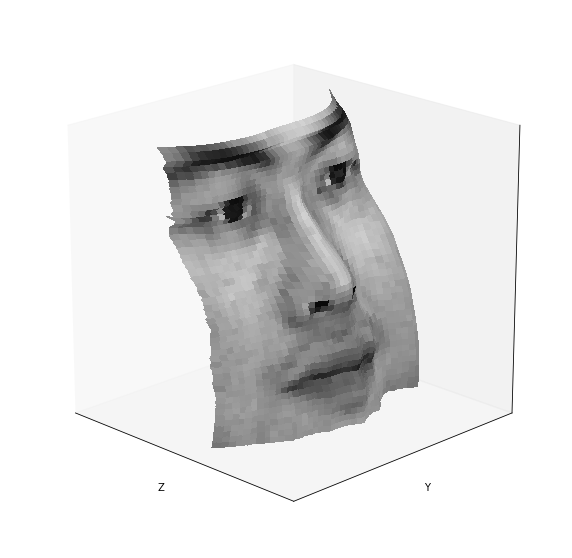

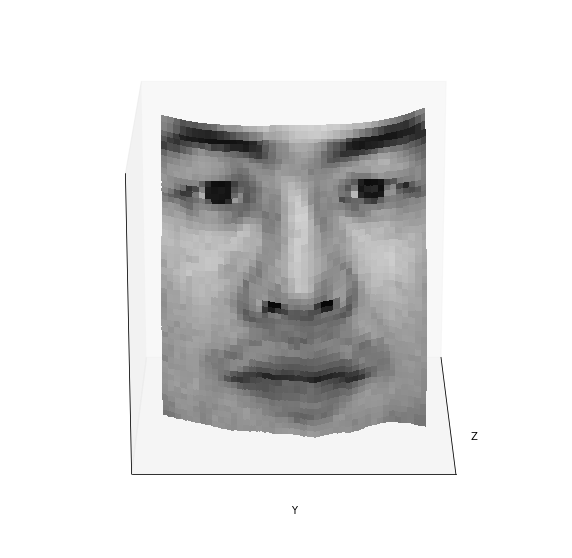

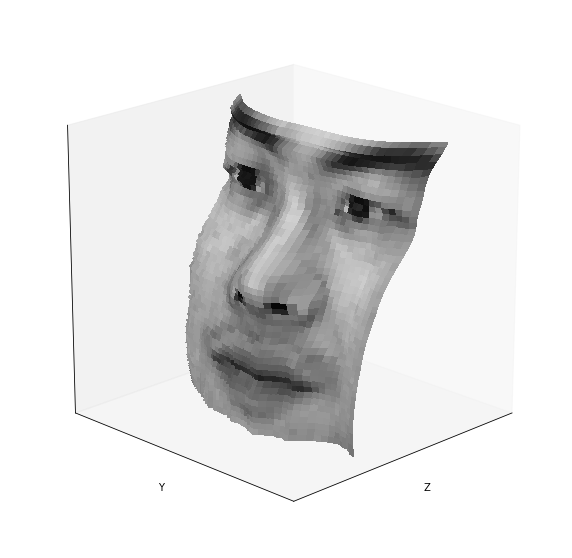

In [24]:
subject_name = 'yaleB02'
integration_method = 'random'
print("Start running on subject: ", subject_name)
full_path = '%s%s' % (root_path, subject_name)
ambient_image, imarray, light_dirs = LoadFaceImages(full_path, subject_name, 64)
processed_imarray = preprocess(ambient_image, imarray)
albedo_image, surface_normals = photometric_stereo(processed_imarray, light_dirs)
height_map = get_surface(surface_normals, integration_method)
                                 
display_3d(albedo_image, height_map, azim=-45)
display_3d(albedo_image, height_map, azim=0)
display_3d(albedo_image, height_map, azim=45)
save_outputs("yaletest02", albedo_image, surface_normals)